Underfitting & Overfitting

In [2]:
"""Model Selection, Underfitting and Overfitting"""
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
"""
By using three order polynomial formula to generate labels of training data and validation data
training data: training
validation data: fine-tuning hyperparameters
test data: testing generalization ability
"""
""" 
y = 5 + (1.2 * x) - (3.4 * ((x**2) / 2!)) + (5.6 * ((x**3) / 3!)) + ϵ where ϵ ~ N(0, (0.1**2))
"""
max_degree = 20
n_train, n_test = 100, 100 # The number of train and validation samples are both 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) # First four weight parameters

features = np.random.normal(size=(n_train + n_test, 1)) # size=(200, 1)
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]
]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.0908],
         [-0.9169]]),
 tensor([[ 1.0000e+00, -9.0752e-02,  4.1179e-03, -1.2457e-04,  2.8262e-06,
          -5.1297e-08,  7.7588e-10, -1.0059e-11,  1.1411e-13, -1.1506e-15,
           1.0442e-17, -8.6149e-20,  6.5151e-22, -4.5481e-24,  2.9482e-26,
          -1.7837e-28,  1.0117e-30, -5.4009e-33,  2.7230e-35, -1.3006e-37],
         [ 1.0000e+00, -9.1690e-01,  4.2035e-01, -1.2847e-01,  2.9450e-02,
          -5.4005e-03,  8.2528e-04, -1.0810e-04,  1.2390e-05, -1.2622e-06,
           1.1573e-07, -9.6470e-09,  7.3711e-10, -5.1989e-11,  3.4049e-12,
          -2.0813e-13,  1.1927e-14, -6.4330e-16,  3.2769e-17, -1.5814e-18]]),
 tensor([4.8795, 1.7350]))

In [5]:
def evaluate_loss(net, data_iter, loss):
    """Evaluate model loss in the given dataset"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [6]:
from IPython import display

class Animator:  
    """Plot data in animation"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:
    """Cumulate n variables"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def accuracy(y_hat, y):
    """Calculate the number of correct predictions"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def train_epoch_ch3(net, train_iter, loss, updater):
    """Train model for one epoch (See the definition in chapter 3)"""
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad() # Reset gradients back to 0
            l.backward() # Compute gradients
            updater.step() # Update parameters by using gradients
            metric.add(
                float(l) * len(y),
                accuracy(y_hat, y),
                y.size().numel()
            )
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy(net, data_iter):
    """Calculate the accuracy of specific dataset"""
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """Train model (See the definition in chapter 3)"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [7]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(
        nn.Linear(input_shape, 1, bias=False) # There is no need to add bias, because the noises have been already added into the formula
    )
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])
    for epoch in range(num_epochs):
        # d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1,
                         (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss))
                         )
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9970775  1.1918097 -3.388796   5.6025467]]


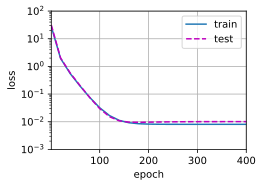

In [8]:
"""Normal training"""
train(poly_features[:n_train, :4], # Only feeding four samples into training process
      poly_features[n_train:, :4],
      labels[:n_train], 
      labels[n_train:]
    )

weight: [[3.294679  3.9413688]]


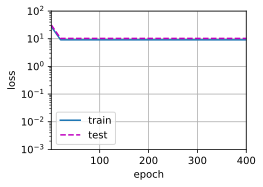

In [9]:
"""Underfitting"""
train(poly_features[:n_train, :2], # Only feeding two samples into training process
      poly_features[n_train:, :2],
      labels[:n_train], 
      labels[n_train:]
    )

weight: [[ 4.971409    1.2984874  -3.27504     5.065963   -0.29910782  1.332966
   0.14672223  0.17010027 -0.21456842 -0.03241421  0.04400984 -0.16297385
  -0.19863881 -0.08332027 -0.15615271  0.17833926 -0.19303282  0.21572869
   0.09959742 -0.03787285]]


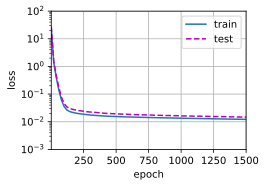

In [10]:
"""Overfitting"""
train(poly_features[:n_train, :], # Feeding all samples into training process
      poly_features[n_train:, :],
      labels[:n_train], 
      labels[n_train:],
      num_epochs=1500
    )